In [58]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.calibration import calibration_curve

In [26]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [48]:
data = np.load('data.npy')
labels = np.load('labels.npy')
data = data.astype('float32') / 255.0
data = data.reshape(-1, 32, 32, 3)

labels = to_categorical(labels, 10)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [51]:
test_batch = unpickle('test_batch')
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']
test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_data = test_data.astype('float32') / 255.0
test_data = test_data.reshape(-1, 32, 32, 3)
print("Test Data shape:", test_data.shape)
print("Test Labels shape:", test_labels.shape)

Test Data shape: (10000, 32, 32, 3)
Test Labels shape: (10000,)


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
# Fully connected
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-06-06 22:12:52.000677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
625/625 [==============================] - 14s 22ms/step - loss: 1.9033 - accuracy: 0.2901 - val_loss: 1.5996 - val_accuracy: 0.4088
Epoch 2/100
625/625 [==============================] - 13s 21ms/step - loss: 1.6191 - accuracy: 0.4110 - val_loss: 1.4802 - val_accuracy: 0.4650
Epoch 3/100
625/625 [==============================] - 13s 21ms/step - loss: 1.5088 - accuracy: 0.4594 - val_loss: 1.4074 - val_accuracy: 0.4998
Epoch 4/100
625/625 [==============================] - 16s 26ms/step - loss: 1.4254 - accuracy: 0.4904 - val_loss: 1.3684 - val_accuracy: 0.5079
Epoch 5/100
625/625 [==============================] - 14s 22ms/step - loss: 1.3483 - accuracy: 0.5204 - val_loss: 1.2892 - val_accuracy: 0.5424
Epoch 6/100
625/625 [==============================] - 14s 22ms/step - loss: 1.2920 - accuracy: 0.5413 - val_loss: 1.2576 - val_accuracy: 0.5539
Epoch 7/100
625/625 [==============================] - 13s 21ms/step - loss: 1.2346 - accuracy: 0.5651 - val_loss: 1.2243 - val_ac

In [57]:
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
test_loss, test_accuracy = model.evaluate(test_data, to_categorical(test_labels))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

313/313 [==============================] - 1s 4ms/step - loss: 1.1625 - accuracy: 0.6002
Validation Loss: 1.162460207939148, Validation Accuracy: 0.6001999974250793
313/313 [==============================] - 1s 4ms/step - loss: 1.1943 - accuracy: 0.5893
Test Loss: 1.1942524909973145, Test Accuracy: 0.5892999768257141


In [10]:
plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Tuning hyperparameters

In [15]:
def build(hp):
        model = Sequential()      
        # First layer
        model.add(Conv2D(hp.Int('conv_1_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(hp.Int('conv_2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(hp.Int('conv_3_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        
        # Fully connected layers
        model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=32), activation='relu'))
        model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
        model.add(Dense(10, activation='softmax'))
        model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='categorical_crossentropy', metrics=['accuracy'])
        
        return model

In [16]:
tuner = RandomSearch(
    build,
    objective='val_accuracy',
    max_trials=10, 
    executions_per_trial=1, 
    directory='my_dir',
    project_name='cnn_tuning_2'
)
tuner.search_space_summary()

Search space summary
Default search space size: 6
conv_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_3_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [17]:
tuner.search(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Trial 10 Complete [00h 15m 02s]
val_accuracy: 0.5504999756813049

Best val_accuracy So Far: 0.6136000156402588
Total elapsed time: 12h 02m 48s


In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("The hyperparameter search is complete.")
print(f"Optimal number of units in the first convolutional layer: {best_hps.get('conv_1_units')}")
print(f"Optimal number of units in the second convolutional layer: {best_hps.get('conv_2_units')}")
print(f"Optimal number of units in the third convolutional layer: {best_hps.get('conv_3_units')}")
print(f"Optimal number of units in the dense layer: {best_hps.get('dense_units')}")
print(f"Optimal dropout rate: {best_hps.get('dropout')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

The hyperparameter search is complete.
Optimal number of units in the first convolutional layer: 128
Optimal number of units in the second convolutional layer: 96
Optimal number of units in the third convolutional layer: 128
Optimal number of units in the dense layer: 64
Optimal dropout rate: 0.2
Optimal learning rate: 0.0001


In [7]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=27, validation_data=(X_test, y_test))
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Plot the figure
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
balanced_model = Sequential()

balanced_model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)))
balanced_model.add(Conv2D(128, (3, 3), activation='relu'))
balanced_model.add(MaxPooling2D((2, 2)))
balanced_model.add(Dropout(0.3))
balanced_model.add(Conv2D(128, (3, 3), activation='relu'))
balanced_model.add(Conv2D(128, (3, 3), activation='relu'))
balanced_model.add(MaxPooling2D((2, 2)))
balanced_model.add(Dropout(0.3))

balanced_model.add(Flatten())
balanced_model.add(Dense(512, activation='relu'))
balanced_model.add(Dropout(0.4))
balanced_model.add(Dense(10, activation='softmax'))

balanced_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = balanced_model.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/35
625/625 [==============================] - 326s 521ms/step - loss: 1.9082 - accuracy: 0.2983 - val_loss: 1.6388 - val_accuracy: 0.4080
Epoch 2/35
625/625 [==============================] - 345s 552ms/step - loss: 1.5877 - accuracy: 0.4275 - val_loss: 1.4581 - val_accuracy: 0.4817
Epoch 3/35
625/625 [==============================] - 340s 544ms/step - loss: 1.4654 - accuracy: 0.4718 - val_loss: 1.3857 - val_accuracy: 0.5007
Epoch 4/35
625/625 [==============================] - 372s 595ms/step - loss: 1.3882 - accuracy: 0.5036 - val_loss: 1.3150 - val_accuracy: 0.5349
Epoch 5/35
625/625 [==============================] - 355s 568ms/step - loss: 1.3215 - accuracy: 0.5301 - val_loss: 1.2835 - val_accuracy: 0.5481
Epoch 6/35
625/625 [==============================] - 363s 580ms/step - loss: 1.2632 - accuracy: 0.5522 - val_loss: 1.1873 - val_accuracy: 0.5802
Epoch 7/35
625/625 [==============================] - 368s 589ms/step - loss: 1.2108 - accuracy: 0.5687 - val_loss: 1.1597 -

In [54]:
val_loss, val_accuracy = balanced_model.evaluate(X_test, y_test)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
test_loss, test_accuracy = balanced_model.evaluate(test_data, to_categorical(test_labels))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

313/313 [==============================] - 21s 66ms/step - loss: 0.9230 - accuracy: 0.7003
Validation Loss: 0.9230173826217651, Validation Accuracy: 0.7002999782562256
313/313 [==============================] - 21s 68ms/step - loss: 0.9227 - accuracy: 0.6985
Test Loss: 0.9227094650268555, Test Accuracy: 0.6984999775886536


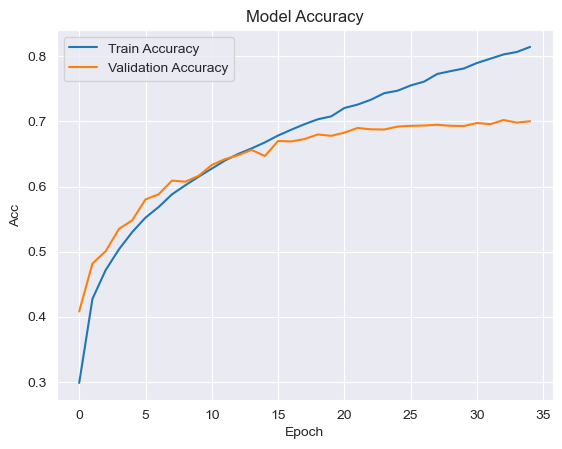

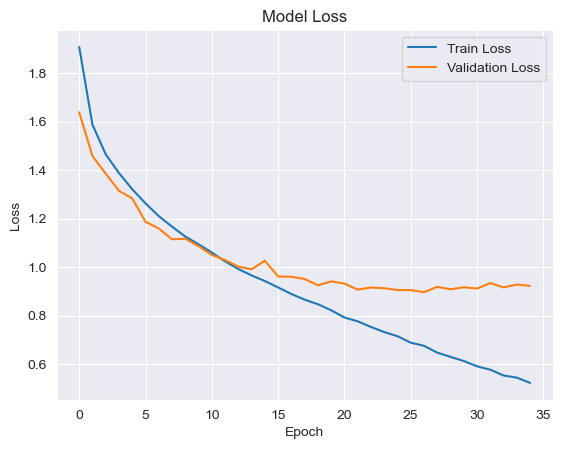

In [9]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
# use test dataset to verify 
indices = np.random.choice(len(test_data), 10, replace=False)
test_images = test_data[indices]
true_labels = test_labels[indices]
predictions = np.argmax(balanced_model.predict(test_images), axis=1)

# Count the number of correct predictions
correct_predictions = np.sum(predictions == true_labels)

print(f"Number of correct predictions out of 10: {correct_predictions}")

1/1 [==============================] - 0s 37ms/step
Number of correct predictions out of 10: 7


313/313 [==============================] - 22s 71ms/step


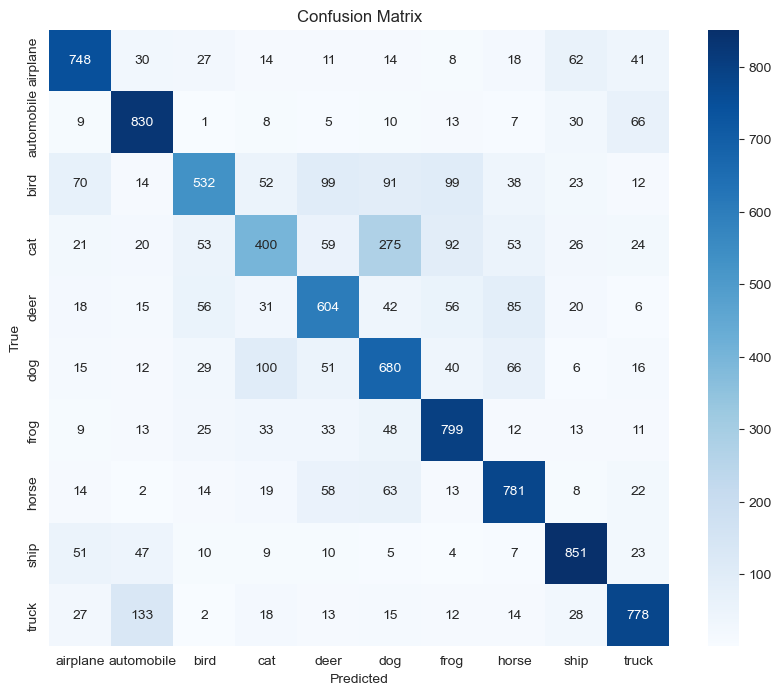

In [55]:
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
predictions = balanced_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labelNames, yticklabels=labelNames)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
start_time = time.time()
predictions = balanced_model.predict(test_data)
total_time = time.time() - start_time

prediction_time_per_example = (total_time / 10000) * 1000  # in milliseconds
print(f"Prediction time per example: {prediction_time_per_example:.4f} ms")

313/313 [==============================] - 25s 78ms/step
Prediction time per example: 2.4636 ms


313/313 [==============================] - 21s 67ms/step


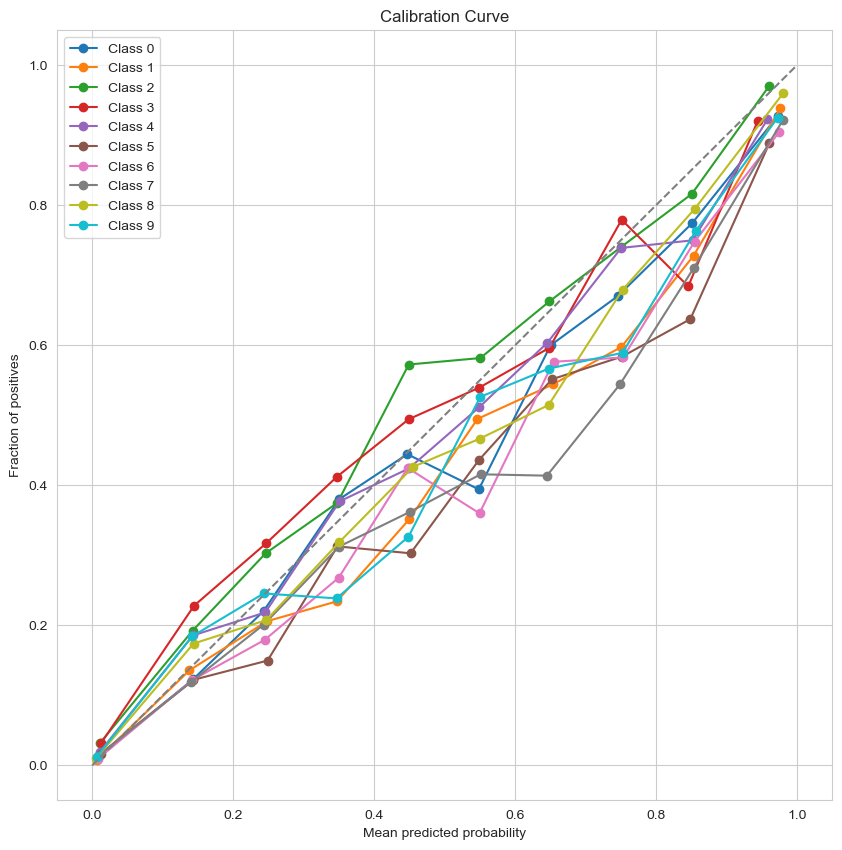

In [59]:
probabilities = balanced_model.predict(test_data)
true_labels = to_categorical(test_labels, num_classes=10)
plt.figure(figsize=(10, 10))
for i in range(10):
    prob_true, prob_pred = calibration_curve(true_labels[:, i], probabilities[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='best')
plt.show()